<a href="https://colab.research.google.com/github/costpetrides/Fluid-Dynamics/blob/main/Raleigh-Taylor-Instability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

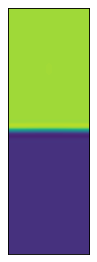

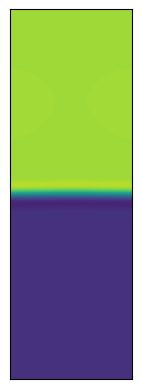

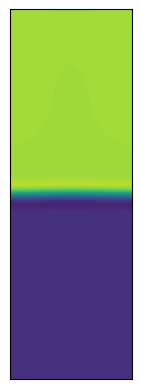

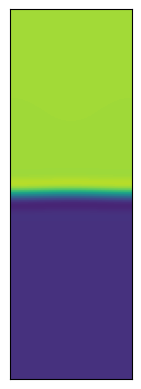

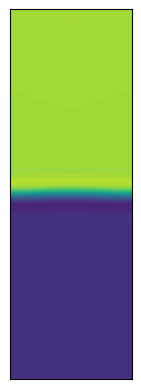

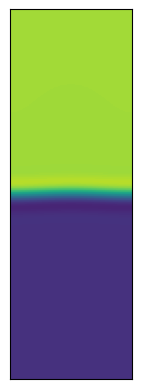

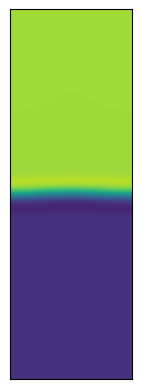

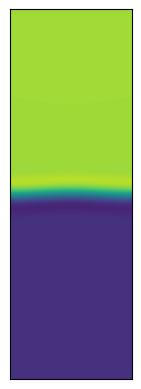

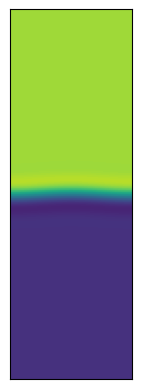

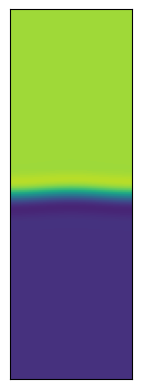

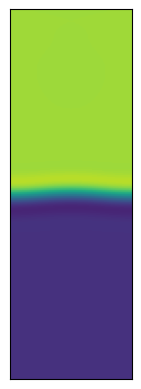

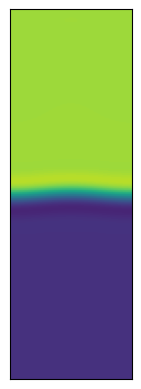

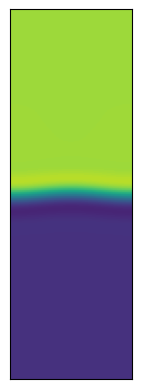

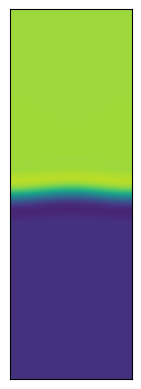

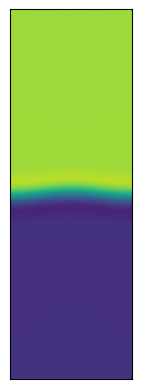

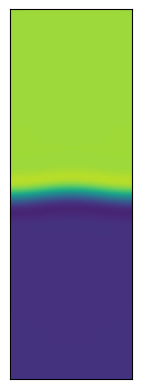

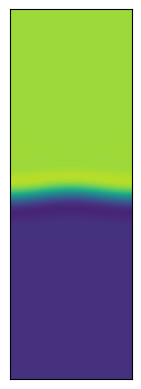

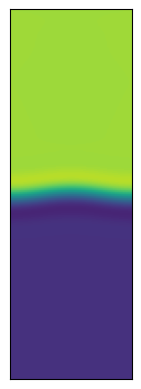

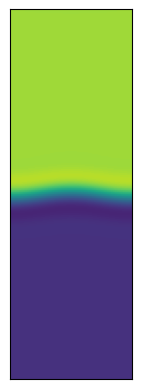

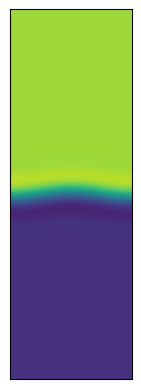

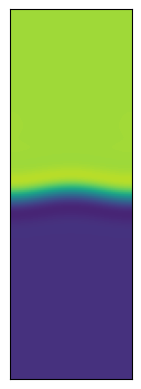

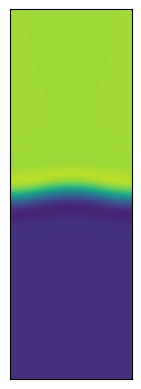

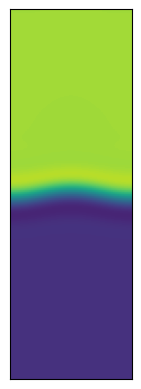

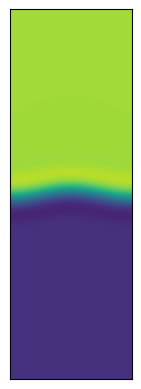

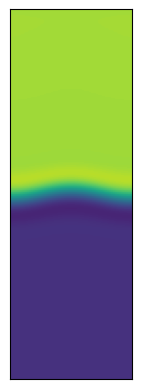

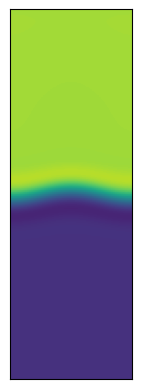

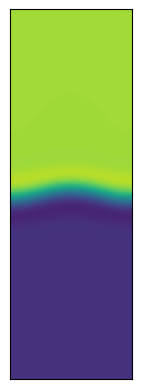

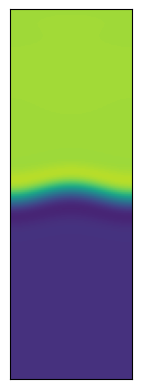

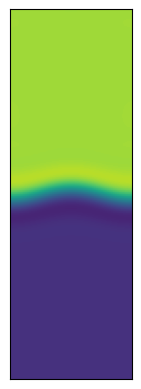

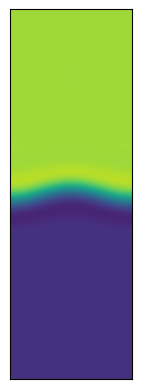

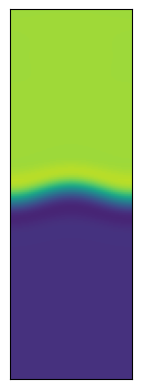

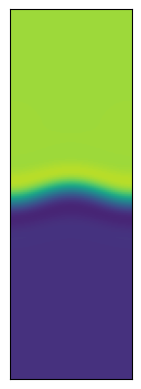

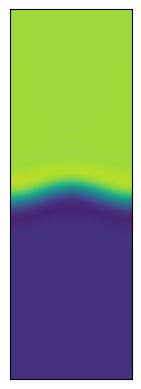

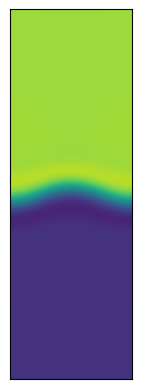

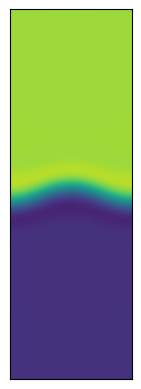

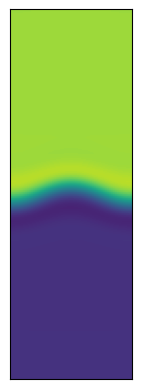

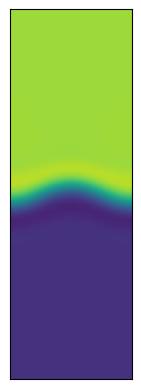

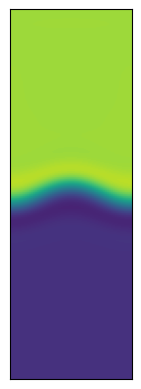

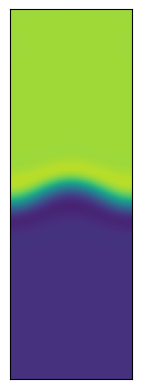

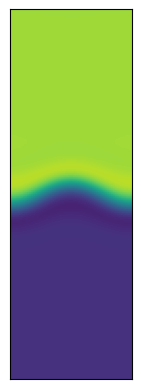

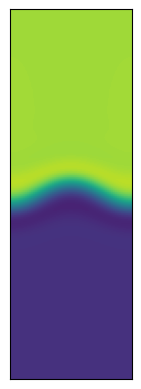

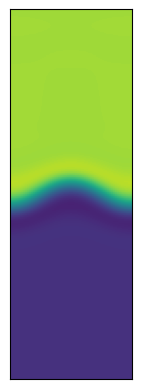

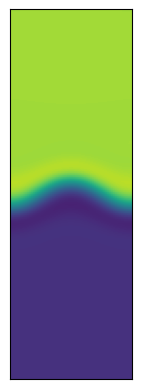

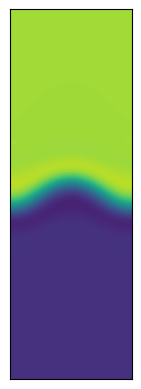

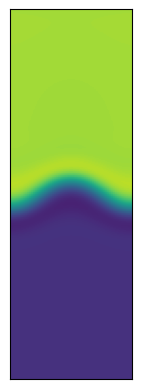

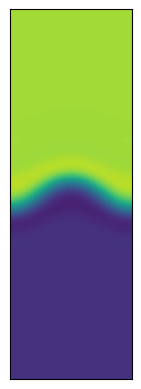

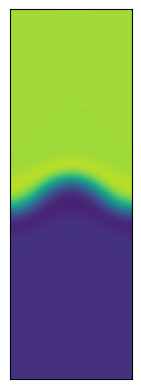

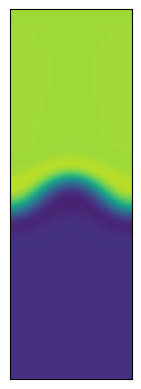

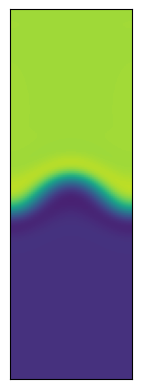

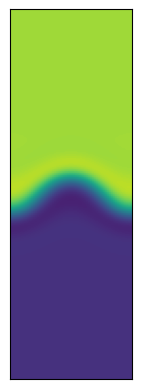

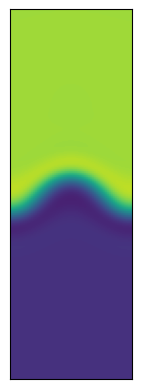

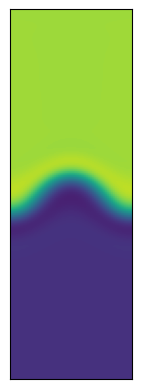

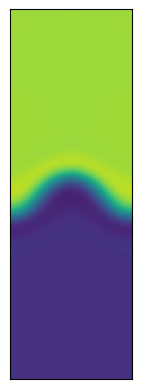

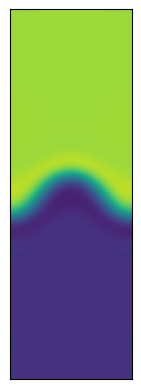

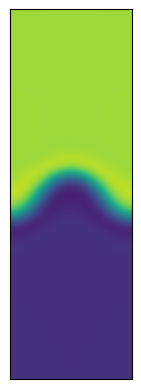

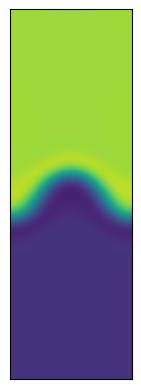

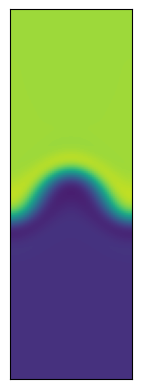

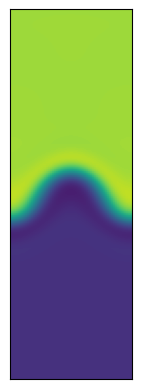

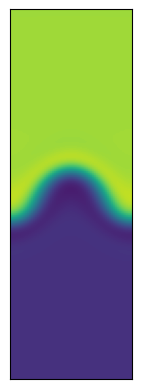

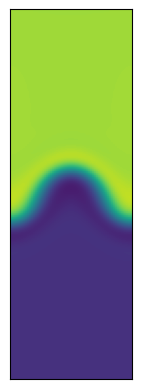

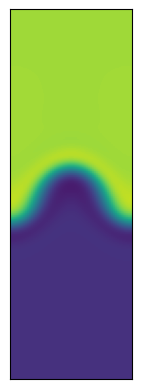

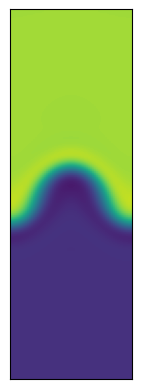

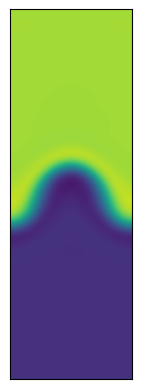

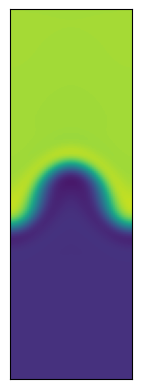

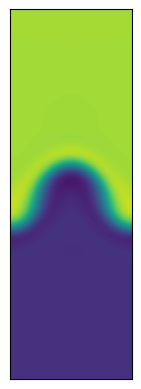

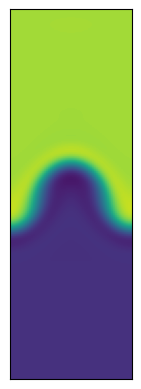

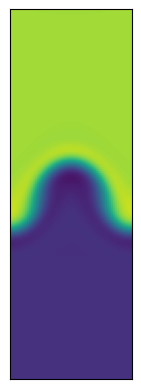

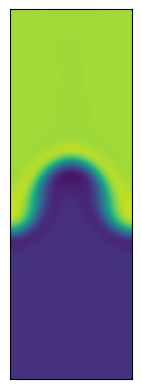

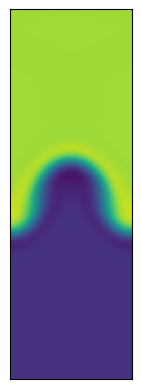

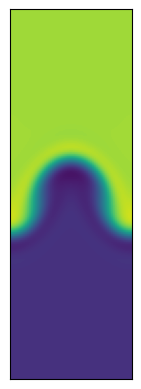

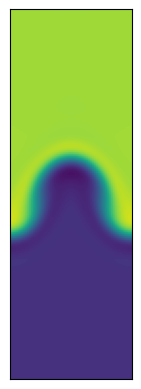

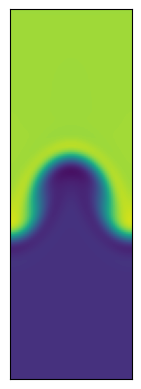

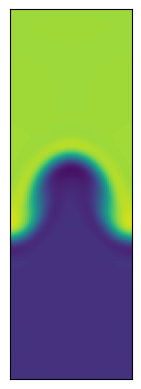

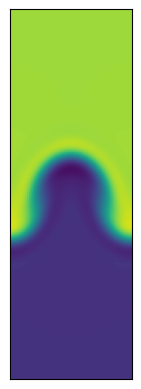

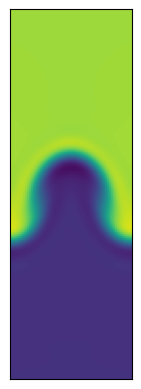

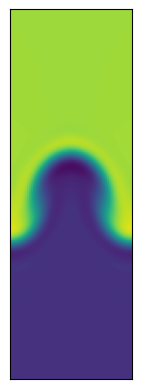

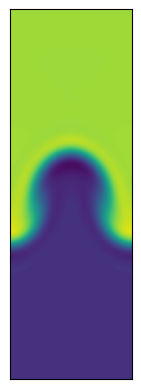

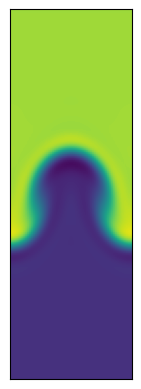

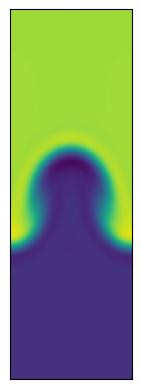

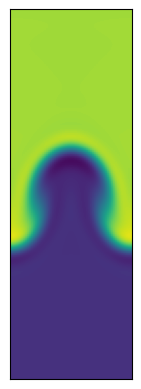

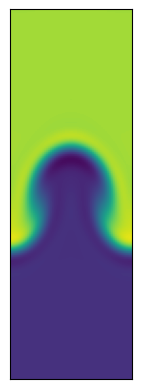

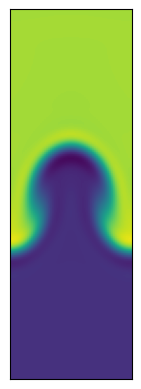

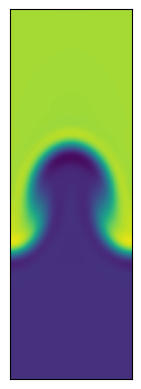

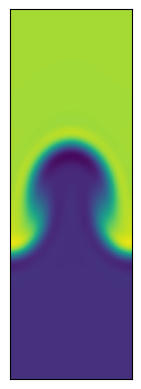

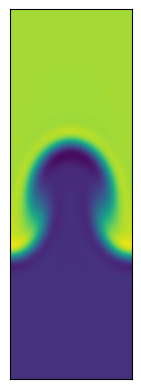

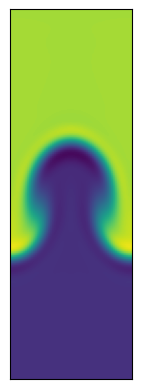

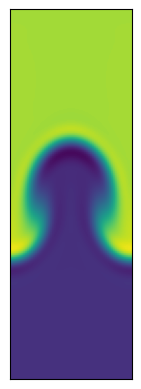

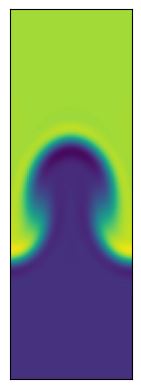

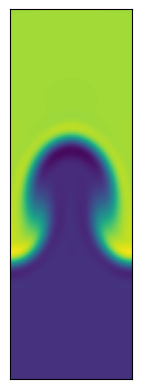

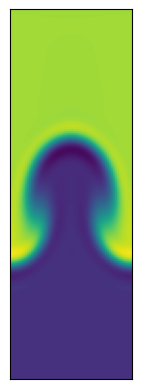

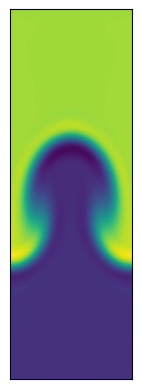

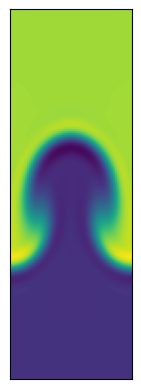

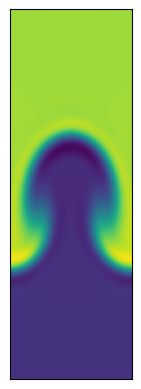

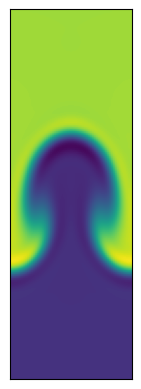

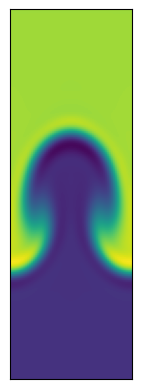

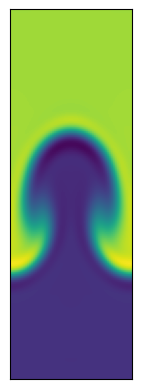

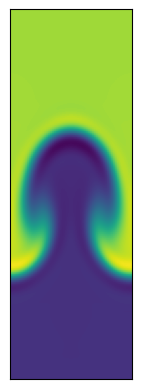

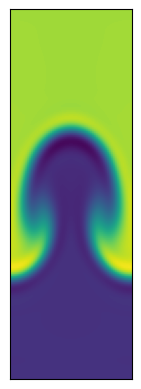

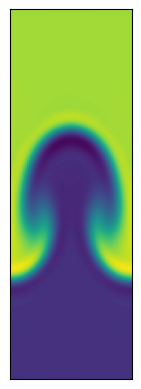

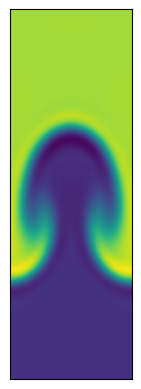

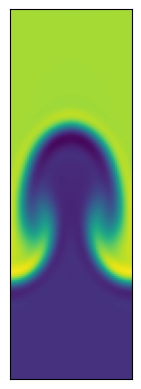

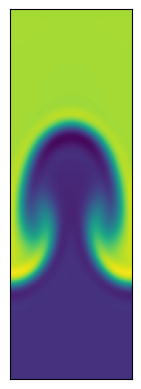

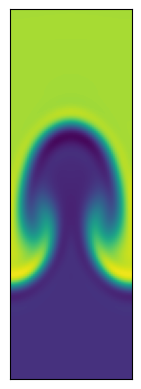

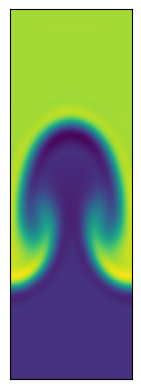

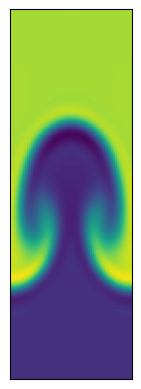

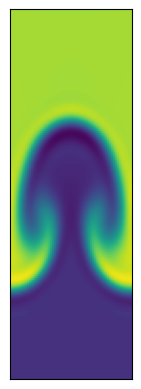

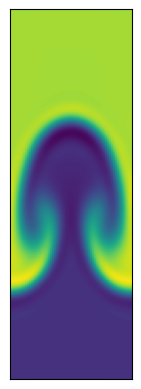

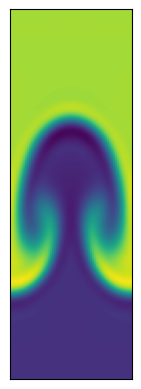

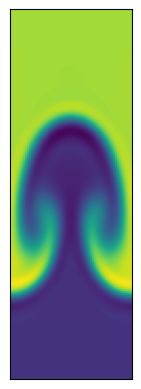

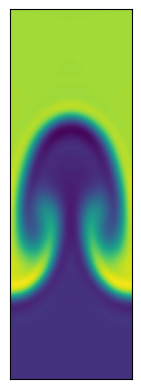

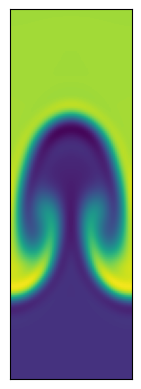

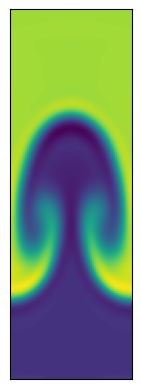

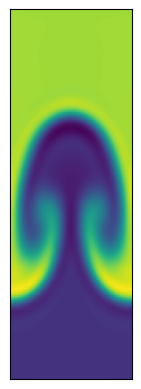

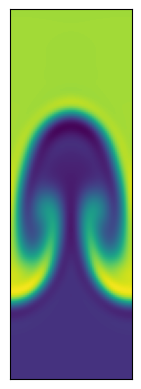

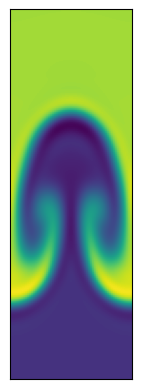

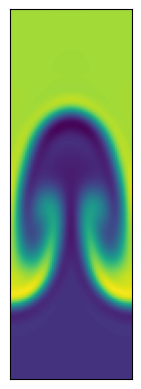

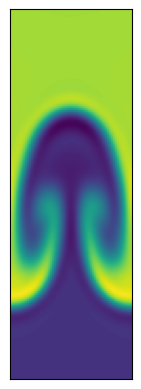

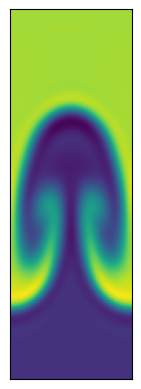

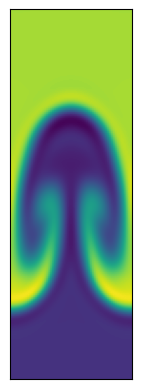

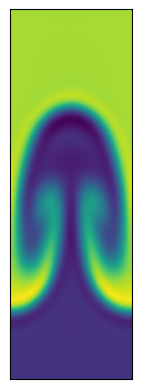

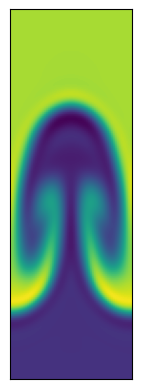

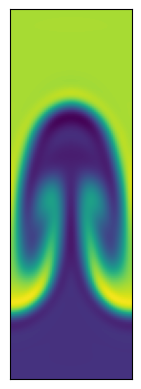

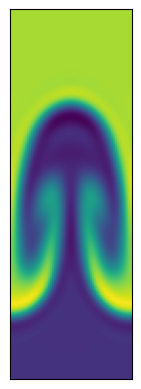

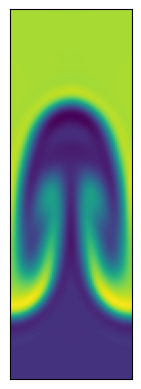

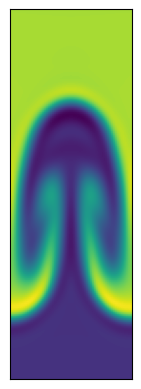

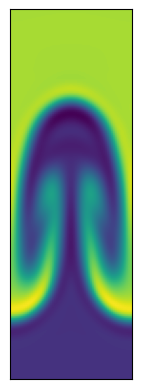

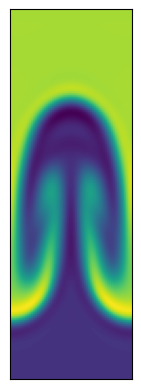

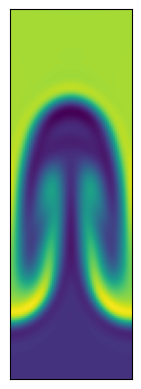

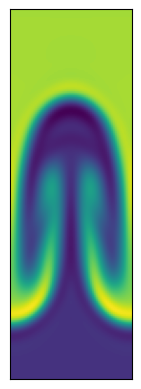

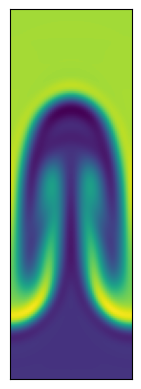

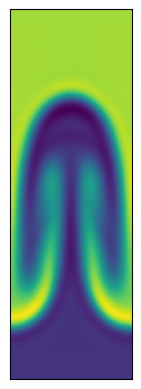

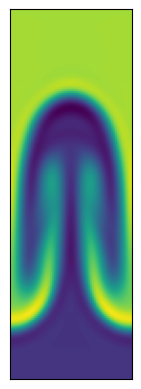

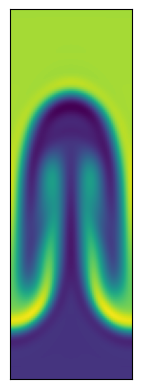

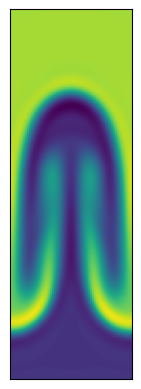

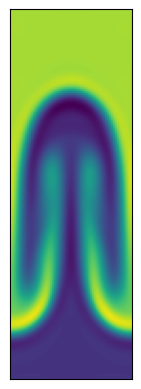

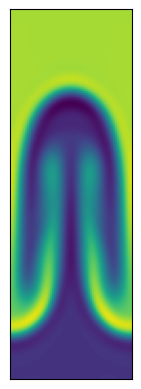

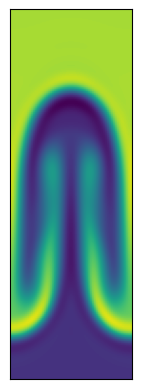

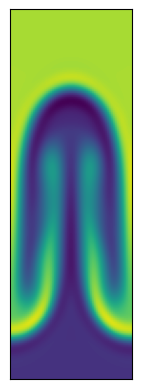

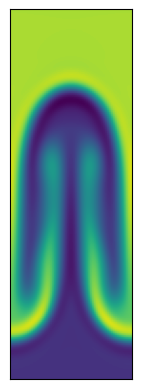

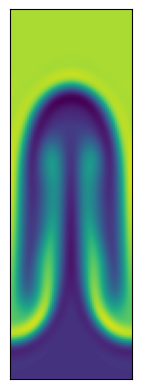

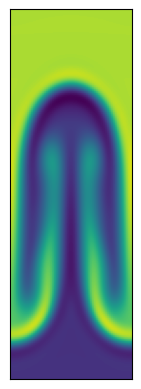

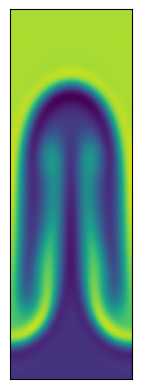

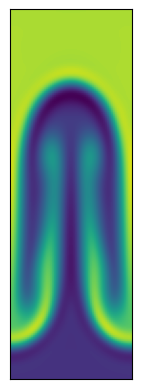

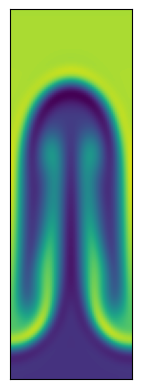

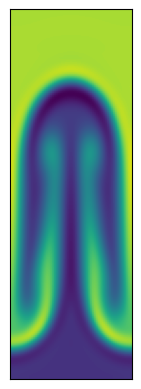

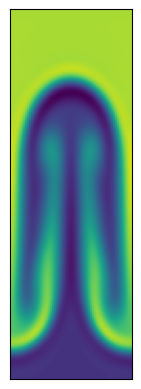

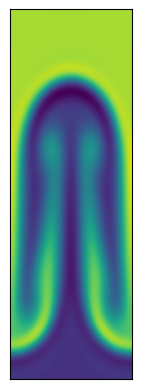

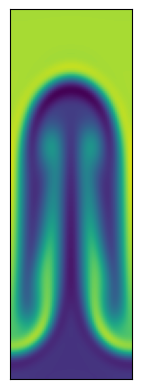

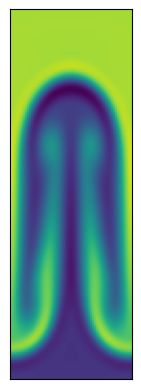

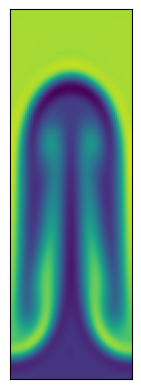

<Figure size 640x480 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

"""
Create Your Own Finite Volume Fluid Simulation (With Python) Part 2:
Boundary Conditions and Source Terms
Philip Mocz (2021), @PMocz

Simulate the Raleigh-Taylor Instability with the Finite Volume Method.
Demonstrates gravity source term and Reflecting boundary condition

"""


def getConserved( rho, vx, vy, P, gamma, vol ):
	"""
    Calculate the conserved variable from the primitive
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	gamma    is ideal gas gamma
	vol      is cell volume
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Momy     is matrix of y-momentum in cells
	Energy   is matrix of energy in cells
	"""
	Mass   = rho * vol
	Momx   = rho * vx * vol
	Momy   = rho * vy * vol
	Energy = (P/(gamma-1) + 0.5*rho*(vx**2+vy**2))*vol

	return Mass, Momx, Momy, Energy


def getPrimitive( Mass, Momx, Momy, Energy, gamma, vol ):
	"""
    Calculate the primitive variable from the conservative
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Momy     is matrix of y-momentum in cells
	Energy   is matrix of energy in cells
	gamma    is ideal gas gamma
	vol      is cell volume
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	"""
	rho = Mass / vol
	vx  = Momx / rho / vol
	vy  = Momy / rho / vol
	P   = (Energy/vol - 0.5*rho * (vx**2+vy**2)) * (gamma-1)

	rho, vx, vy, P = setGhostCells(rho, vx, vy, P)

	return rho, vx, vy, P


def getGradient(f, dx):
	"""
    Calculate the gradients of a field
	f        is a matrix of the field
	dx       is the cell size
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""
	# directions for np.roll()
	R = -1   # right
	L = 1    # left

	f_dx = ( np.roll(f,R,axis=0) - np.roll(f,L,axis=0) ) / (2*dx)
	f_dy = ( np.roll(f,R,axis=1) - np.roll(f,L,axis=1) ) / (2*dx)

	f_dx, f_dy = setGhostGradients(f_dx, f_dy)

	return f_dx, f_dy


def slopeLimit(f, dx, f_dx, f_dy):
	"""
    Apply slope limiter to slopes
	f        is a matrix of the field
	dx       is the cell size
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""
	# directions for np.roll()
	R = -1   # right
	L = 1    # left

	f_dx = np.maximum(0., np.minimum(1., ( (f-np.roll(f,L,axis=0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
	f_dx = np.maximum(0., np.minimum(1., (-(f-np.roll(f,R,axis=0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
	f_dy = np.maximum(0., np.minimum(1., ( (f-np.roll(f,L,axis=1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy
	f_dy = np.maximum(0., np.minimum(1., (-(f-np.roll(f,R,axis=1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy

	return f_dx, f_dy


def extrapolateInSpaceToFace(f, f_dx, f_dy, dx):
	"""
    Calculate the gradients of a field
	f        is a matrix of the field
	f_dx     is a matrix of the field x-derivatives
	f_dy     is a matrix of the field y-derivatives
	dx       is the cell size
	f_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
	f_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
	f_YR     is a matrix of spatial-extrapolated values on `left' face along y-axis
	f_YR     is a matrix of spatial-extrapolated values on `right' face along y-axis
	"""
	# directions for np.roll()
	R = -1   # right
	L = 1    # left

	f_XL = f - f_dx * dx/2
	f_XL = np.roll(f_XL,R,axis=0)
	f_XR = f + f_dx * dx/2

	f_YL = f - f_dy * dx/2
	f_YL = np.roll(f_YL,R,axis=1)
	f_YR = f + f_dy * dx/2

	return f_XL, f_XR, f_YL, f_YR


def applyFluxes(F, flux_F_X, flux_F_Y, dx, dt):
	"""
    Apply fluxes to conserved variables
	F        is a matrix of the conserved variable field
	flux_F_X is a matrix of the x-dir fluxes
	flux_F_Y is a matrix of the y-dir fluxes
	dx       is the cell size
	dt       is the timestep
	"""
	# directions for np.roll()
	R = -1   # right
	L = 1    # left

	# update solution
	F += - dt * dx * flux_F_X
	F +=   dt * dx * np.roll(flux_F_X,L,axis=0)
	F += - dt * dx * flux_F_Y
	F +=   dt * dx * np.roll(flux_F_Y,L,axis=1)

	return F


def getFlux(rho_L, rho_R, vx_L, vx_R, vy_L, vy_R, P_L, P_R, gamma):
	"""
    Calculate fluxed between 2 states with local Lax-Friedrichs/Rusanov rule
	rho_L        is a matrix of left-state  density
	rho_R        is a matrix of right-state density
	vx_L         is a matrix of left-state  x-velocity
	vx_R         is a matrix of right-state x-velocity
	vy_L         is a matrix of left-state  y-velocity
	vy_R         is a matrix of right-state y-velocity
	P_L          is a matrix of left-state  pressure
	P_R          is a matrix of right-state pressure
	gamma        is the ideal gas gamma
	flux_Mass    is the matrix of mass fluxes
	flux_Momx    is the matrix of x-momentum fluxes
	flux_Momy    is the matrix of y-momentum fluxes
	flux_Energy  is the matrix of energy fluxes
	"""

	# left and right energies
	en_L = P_L/(gamma-1)+0.5*rho_L * (vx_L**2+vy_L**2)
	en_R = P_R/(gamma-1)+0.5*rho_R * (vx_R**2+vy_R**2)

	# compute star (averaged) states
	rho_star  = 0.5*(rho_L + rho_R)
	momx_star = 0.5*(rho_L * vx_L + rho_R * vx_R)
	momy_star = 0.5*(rho_L * vy_L + rho_R * vy_R)
	en_star   = 0.5*(en_L + en_R)

	P_star = (gamma-1)*(en_star-0.5*(momx_star**2+momy_star**2)/rho_star)

	# compute fluxes (local Lax-Friedrichs/Rusanov)
	flux_Mass   = momx_star
	flux_Momx   = momx_star**2/rho_star + P_star
	flux_Momy   = momx_star * momy_star/rho_star
	flux_Energy = (en_star+P_star) * momx_star/rho_star

	# find wavespeeds
	C_L = np.sqrt(gamma*P_L/rho_L) + np.abs(vx_L)
	C_R = np.sqrt(gamma*P_R/rho_R) + np.abs(vx_R)
	C = np.maximum( C_L, C_R )

	# add stabilizing diffusive term
	flux_Mass   -= C * 0.5 * (rho_L - rho_R)
	flux_Momx   -= C * 0.5 * (rho_L * vx_L - rho_R * vx_R)
	flux_Momy   -= C * 0.5 * (rho_L * vy_L - rho_R * vy_R)
	flux_Energy -= C * 0.5 * ( en_L - en_R )

	return flux_Mass, flux_Momx, flux_Momy, flux_Energy

def addGhostCells( rho, vx, vy, P ):
	"""
    Add ghost cells to the top and bottom
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	"""
	rho = np.hstack((rho[:,0:1], rho, rho[:,-1:]))
	vx  = np.hstack(( vx[:,0:1],  vx,  vx[:,-1:]))
	vy  = np.hstack(( vy[:,0:1],  vy,  vy[:,-1:]))
	P   = np.hstack((  P[:,0:1],   P,   P[:,-1:]))

	return rho, vx, vy, P

def setGhostCells( rho, vx, vy, P ):
	"""
    Set ghost cells at the top and bottom
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	"""

	rho[:,0]  = rho[:,1]
	vx[:,0]   =  vx[:,1]
	vy[:,0]   = -vy[:,1]
	P[:,0]    =   P[:,1]

	rho[:,-1] = rho[:,-2]
	vx[:,-1]  =  vx[:,-2]
	vy[:,-1]  = -vy[:,-2]
	P[:,-1]   =   P[:,-2]

	return rho, vx, vy, P

def setGhostGradients( f_dx, f_dy ):
	"""
    Set ghost cell y-gradients at the top and bottom to be reflections
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""

	f_dy[:,0]  = -f_dy[:,1]
	f_dy[:,-1] = -f_dy[:,-2]

	return f_dx, f_dy

def addSourceTerm( Mass, Momx, Momy, Energy, g, dt ):
	"""
    Add gravitational source term to conservative variables
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Momy     is matrix of y-momentum in cells
	Energy   is matrix of energy in cells
	g        is strength of gravity
	Y        is matrix of y positions of cells
	dt       is timestep to progress solution
	"""

	Energy += dt * Momy * g
	Momy += dt * Mass * g

	return Mass, Momx, Momy, Energy


def main():
	""" Finite Volume simulation """

	# Simulation parameters
	N                      = 64 # resolution N x 3N
	boxsizeX               = 0.5
	boxsizeY               = 1.5
	gamma                  = 1.4 # ideal gas gamma
	courant_fac            = 0.4
	t                      = 0
	tEnd                   = 15
	tOut                   = 0.1 # draw frequency
	useSlopeLimiting       = False
	plotRealTime = True # switch on for plotting as the simulation goes along

	# Mesh
	dx = boxsizeX / N
	vol = dx**2
	xlin = np.linspace(0.5*dx, boxsizeX-0.5*dx, N)
	ylin = np.linspace(0.5*dx, boxsizeY-0.5*dx, 3*N)
	Y, X = np.meshgrid( ylin, xlin )

	# Generate Initial Conditions - heavy fluid on top of light, with perturbation
	g = -0.1  # gravity
	w0 = 0.0025
	P0 = 2.5
	rho = 1. + (Y > 0.75)
	vx = np.zeros(X.shape)
	vy = w0 * (1-np.cos(4*np.pi*X)) * (1-np.cos(4*np.pi*Y/3))
	P = P0 + g * (Y-0.75) * rho

	rho, vx, vy, P = addGhostCells(rho, vx, vy, P)

	# Get conserved variables
	Mass, Momx, Momy, Energy = getConserved( rho, vx, vy, P, gamma, vol )

	# prep figure
	fig = plt.figure(figsize=(4,4), dpi=80)
	outputCount = 1

	# Simulation Main Loop
	while t < tEnd:

		# get Primitive variables
		rho, vx, vy, P = getPrimitive( Mass, Momx, Momy, Energy, gamma, vol )

		# get time step (CFL) = dx / max signal speed
		dt = courant_fac * np.min( dx / (np.sqrt( gamma*P/rho ) + np.sqrt(vx**2+vy**2)) )
		plotThisTurn = False
		if t + dt > outputCount*tOut:
			dt = outputCount*tOut - t
			plotThisTurn = True

		# Add Source (half-step)
		Mass, Momx, Momy, Energy = addSourceTerm( Mass, Momx, Momy, Energy, g, dt/2 )

		# get Primitive variables
		rho, vx, vy, P = getPrimitive( Mass, Momx, Momy, Energy, gamma, vol )

		# calculate gradients
		rho_dx, rho_dy = getGradient(rho, dx)
		vx_dx,  vx_dy  = getGradient(vx,  dx)
		vy_dx,  vy_dy  = getGradient(vy,  dx)
		P_dx,   P_dy   = getGradient(P,   dx)

		# slope limit gradients
		if useSlopeLimiting:
			rho_dx, rho_dy = slopeLimit(rho, dx, rho_dx, rho_dy)
			vx_dx,  vx_dy  = slopeLimit(vx , dx, vx_dx,  vx_dy )
			vy_dx,  vy_dy  = slopeLimit(vy , dx, vy_dx,  vy_dy )
			P_dx,   P_dy   = slopeLimit(P  , dx, P_dx,   P_dy  )

		# extrapolate half-step in time
		rho_prime = rho - 0.5*dt * ( vx * rho_dx + rho * vx_dx + vy * rho_dy + rho * vy_dy)
		vx_prime  = vx  - 0.5*dt * ( vx * vx_dx + vy * vx_dy + (1/rho) * P_dx )
		vy_prime  = vy  - 0.5*dt * ( vx * vy_dx + vy * vy_dy + (1/rho) * P_dy )
		P_prime   = P   - 0.5*dt * ( gamma*P * (vx_dx + vy_dy)  + vx * P_dx + vy * P_dy )

		# extrapolate in space to face centers
		rho_XL, rho_XR, rho_YL, rho_YR = extrapolateInSpaceToFace(rho_prime, rho_dx, rho_dy, dx)
		vx_XL,  vx_XR,  vx_YL,  vx_YR  = extrapolateInSpaceToFace(vx_prime,  vx_dx,  vx_dy,  dx)
		vy_XL,  vy_XR,  vy_YL,  vy_YR  = extrapolateInSpaceToFace(vy_prime,  vy_dx,  vy_dy,  dx)
		P_XL,   P_XR,   P_YL,   P_YR   = extrapolateInSpaceToFace(P_prime,   P_dx,   P_dy,   dx)

		# compute fluxes (local Lax-Friedrichs/Rusanov)
		flux_Mass_X, flux_Momx_X, flux_Momy_X, flux_Energy_X = getFlux(rho_XL, rho_XR, vx_XL, vx_XR, vy_XL, vy_XR, P_XL, P_XR, gamma)
		flux_Mass_Y, flux_Momy_Y, flux_Momx_Y, flux_Energy_Y = getFlux(rho_YL, rho_YR, vy_YL, vy_YR, vx_YL, vx_YR, P_YL, P_YR, gamma)

		# update solution
		Mass   = applyFluxes(Mass, flux_Mass_X, flux_Mass_Y, dx, dt)
		Momx   = applyFluxes(Momx, flux_Momx_X, flux_Momx_Y, dx, dt)
		Momy   = applyFluxes(Momy, flux_Momy_X, flux_Momy_Y, dx, dt)
		Energy = applyFluxes(Energy, flux_Energy_X, flux_Energy_Y, dx, dt)

		# Add Source (half-step)
		Mass, Momx, Momy, Energy = addSourceTerm( Mass, Momx, Momy, Energy, g, dt/2 )

		# update time
		t += dt

		# plot in real time - color 1/2 particles blue, other half red
		if (plotRealTime and plotThisTurn) or (t >= tEnd):
			plt.cla()
			plt.imshow(rho.T)
			plt.clim(0.8, 2.2)
			ax = plt.gca()
			ax.invert_yaxis()
			ax.get_xaxis().set_visible(False)
			ax.get_yaxis().set_visible(False)
			ax.set_aspect('equal')
			plt.pause(0.001)
			outputCount += 1


	# Save figure
	plt.savefig('finitevolume2.png',dpi=240)
	plt.show()

	return 0



if __name__== "__main__":
  main()
